In [1]:
import time

from PIL import Image
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import corpus_bleu
import numpy as np
import torch

from model import SAT
from util import CocoCaptionDataset, load_square, prepare_image

In [2]:
checkpoint_path = "logs/default/version_54/last.ckpt"

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = SAT.load_from_checkpoint(checkpoint_path, map_location=device).to(device)
model.freeze()
valid_ds = CocoCaptionDataset(jsonpath=model.hparams.json, split="test")

idx = 889
Caption 0 : a close up of two cell phones near one another
Caption 1 : two mobile devices are lying on a table
Caption 2 : two cell phones of <UNK> <UNK> are set side by side on a table
Caption 3 : two cellphones are sitting side by side on the table
Caption 4 : two cell phones are sitting next to each other on a table
Inference in 47.996 ms for beamk=20 and length=9
Prediction 0 (s=1.72, p=2.10) : two cell phones are sitting on a table
Prediction 1 (s=1.60, p=2.14) : two cell phones sitting next to each other
Prediction 2 (s=1.35, p=2.20) : a cell phone sitting next to a keyboard
Prediction 3 (s=1.13, p=2.18) : a cell phone sitting next to a cell phone
Prediction 4 (s=0.90, p=2.33) : two cell phones are sitting on a desk
bleu1 = 0.8049. bleu2 = 0.6852. bleu3 = 0.5849. bleu4 = 0.4617


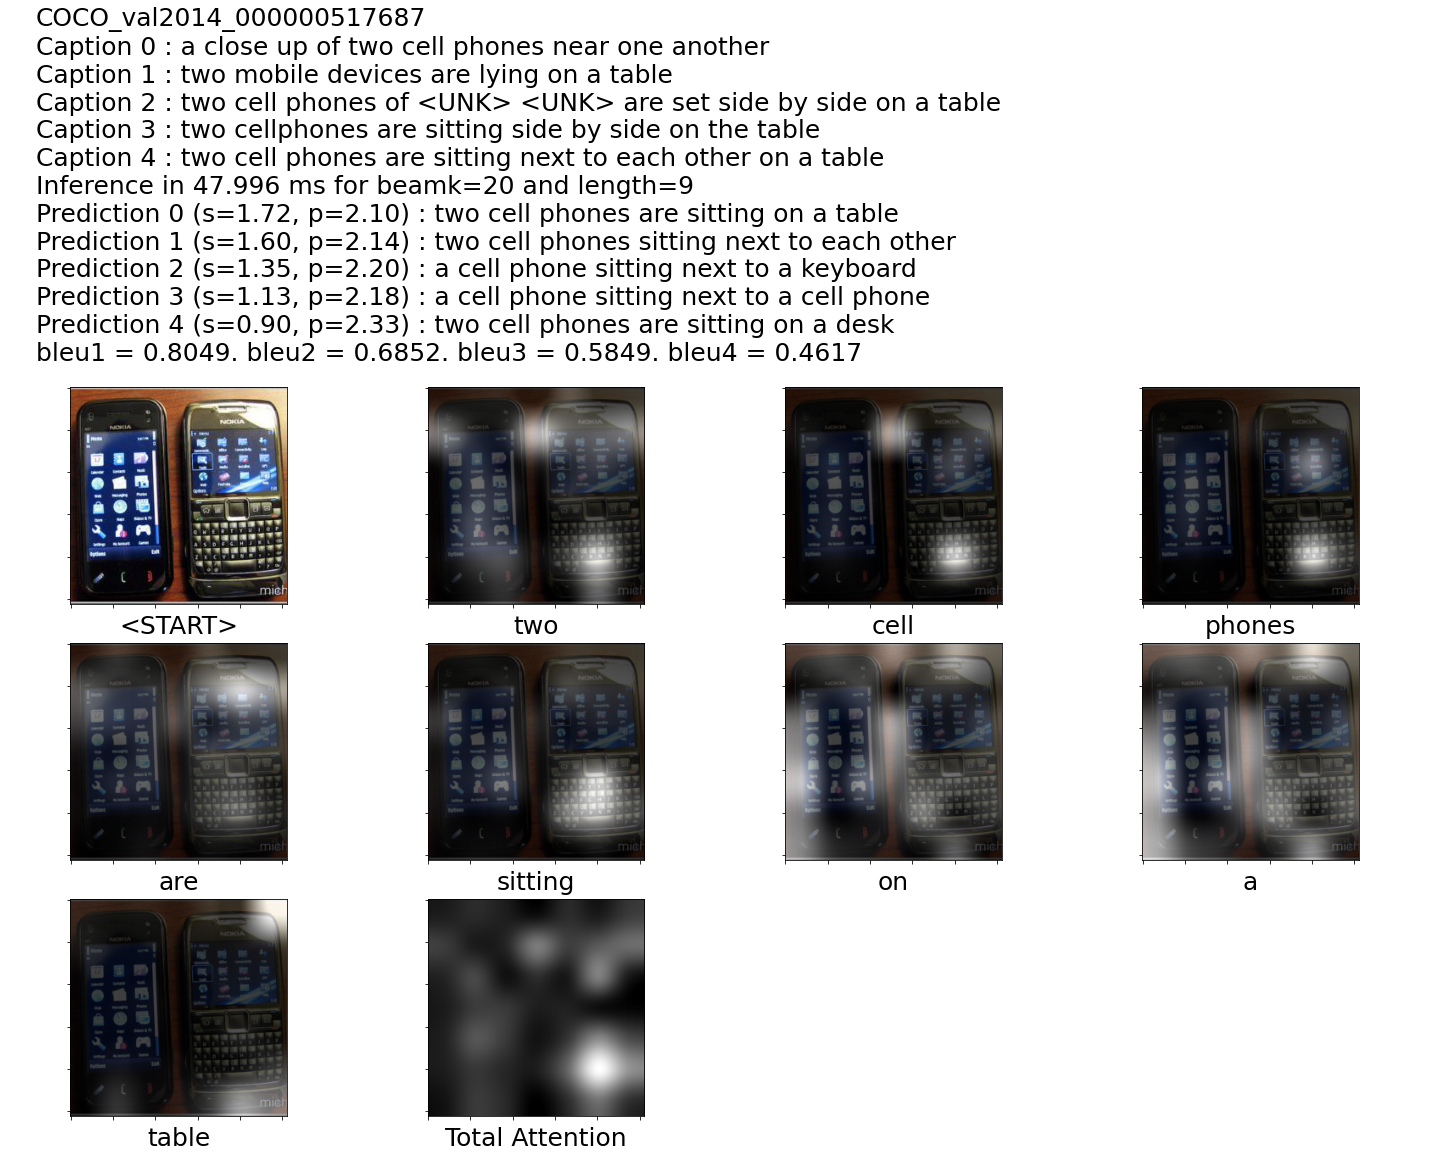

In [123]:
def make_visual(idx, beamk, max_gen_length, temperature, rescore_method, rescore_reward, show_topk=1):
    visual_size = 256
    scale = 5
    font_scale = 5
    columns = 4
    labelpad = 4

    img_path = valid_ds.img_paths[idx]
    img_name = os.path.splitext(os.path.basename(img_path))[0]
    references = [c[1:l] for c, l in zip(valid_ds.encoded_captions[idx], valid_ds.lengths[idx])]
    gt_captions = [" ".join(valid_ds.itos(t) for t in r) for r in references]

    title_str = f"{img_name}\n"
    for i in range(len(gt_captions)):
        cap_str = f"Caption {i} : {gt_captions[i]}"
        title_str += cap_str + "\n"
        print(cap_str)

    img_pil = load_square(img_path, size=visual_size)
    img_ten = prepare_image(img_pil, size=model.hparams.input_size).to(model.device)
    t0 = time.time()
    captions, scores, alphas, perplexities = model.caption(img_ten, beamk, max_gen_length, temperature, rescore_method, rescore_reward, True)
    duration = time.time()-t0
    infer_str = f"Inference in {(duration*1e3):.3f} ms for beamk={beamk} and length={max([len(c) for c in captions[0]])}"
    title_str += infer_str + "\n"
    print(infer_str)

    num_sentences = min(beamk, show_topk)
    for i in range(num_sentences):
        words = model.decode_seq(captions[0][i])
        pred_str = f"Prediction {i} (s={scores[0][i]:.2f}, p={perplexities[0][i]:.2f}) : {' '.join(words)}"
        title_str += pred_str + "\n"
        print(pred_str)

    references_list = [references for i in range(num_sentences)]
    captions_list = captions[0][:num_sentences]
    bleu1 = corpus_bleu(references_list, captions_list, weights=(1, 0, 0, 0))
    bleu2 = corpus_bleu(references_list, captions_list, weights=(0.5, 0.5, 0, 0))
    bleu3 = corpus_bleu(references_list, captions_list, weights=(0.33, 0.33, 0.33, 0))
    bleu4 = corpus_bleu(references_list, captions_list, weights=(0.25, 0.25, 0.25, 0.25))
    bleu_str = f"{bleu1 = :.4f}. {bleu2 = :.4f}. {bleu3 = :.4f}. {bleu4 = :.4f}"
    title_str += bleu_str
    print(bleu_str)

    map_size = model.hparams.encoder_size
    cap_len = len(captions[0][0])
    num_figs = 2+cap_len
    if cap_len<columns: columns=num_figs
    rows = 1 + num_figs//columns

    # Boost the height a little based on output length
    boost = 1 + (8+num_sentences)/(8*scale*font_scale+num_sentences)
    fig = plt.figure(figsize=[scale*columns, boost*scale*rows])
    fig.patch.set_facecolor('w')
    fig.suptitle(title_str, fontsize=scale*font_scale, x=0.03, y=1, horizontalalignment='left')

    # Color image
    plt.axis('off')
    fig.add_subplot(rows, columns, 1)
    ax = plt.gca()
    ax.imshow(img_pil)
    ax.set_xlabel("<START>", fontsize=scale*font_scale, labelpad=labelpad)
    ax.set_yticklabels([])
    ax.set_xticklabels([])

    words = model.decode_seq(captions[0][0])
    atts = alphas[0][0]

    # Attention Alphas
    i = 0  # Failsafe if the prediction is blank
    for i in range(cap_len):
        fig.add_subplot(rows, columns, i+2)
        ax = plt.gca()
        att = atts[i].reshape(map_size, map_size).cpu().numpy()
        att = ( (att-np.min(att))/(np.max(att)-np.min(att)) )**2.0
        mask = Image.fromarray(np.uint8(att*255)).convert('RGB').resize((visual_size, visual_size))
        img = ax.imshow(img_pil)
        ax.imshow(mask, cmap='gray', alpha=0.75, extent=img.get_extent())
        ax.set_xlabel(words[i], fontsize=scale*font_scale, labelpad=labelpad)
        ax.set_yticklabels([])
        ax.set_xticklabels([])

    fig.add_subplot(rows, columns, i+3)
    ax = plt.gca()
    att = atts.sum(0).reshape(map_size, map_size).cpu().numpy()
    att = (att-np.min(att))/(np.max(att)-np.min(att))
    mask = Image.fromarray(np.uint8(att*255)).convert('RGB').resize((visual_size, visual_size))
    ax.imshow(mask)
    ax.set_xlabel("Total Attention", fontsize=scale*font_scale, labelpad=labelpad)
    ax.set_yticklabels([])
    ax.set_xticklabels([])

    fig.tight_layout()

    # plt.savefig(f"data/visualize/{img_name}_result.jpg", bbox_inches="tight")

idx = np.random.randint(0, len(valid_ds.img_paths))
# idx = 1412
print(f"{idx = }")

beamk = 20
max_gen_length = 32
temperature = [1.0, 5.0, 3.0]
temperature = 0.935
show_topk = 5
rescore_method = "BAR"  # LN, WR, BAR
rescore_reward = 1.0

make_visual(idx, beamk, max_gen_length, temperature, rescore_method, rescore_reward, show_topk)